## Transfer Learning with TensorFlow: Scaling up

Scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

### Road Map

1. Downloading and preparing 10% of the Food101 data (10% of training data)
2. Training a feature extraction transfer learning model on 10% of the Food101 training data
3. Fine-tuning our feature extraction model
4. Saving and loaded our trained model
5. Evaluating the performance of our Food Vision model trained on 10% of the training data - Finding our model's most wrong predictions
7. Making predictions with our Food Vision model on custom images of food

Pre-trained model: **EfficientNetB0** (was trained on ImageNet)

Original Dataset: https://www.kaggle.com/datasets/dansbecker/food-101

(1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.)

Reference: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

### Auxiliary Methods

In [ ]:
import os
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  if scale:
    img = img/255.
  return img

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Download a subset of Food101 dataset (10% of the dataset)

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2023-05-18 14:00:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.2MB/s    in 73s     

2023-05-18 14:02:12 (21.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")     

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_per

For the test dataset, we're going to set **shuffle=False** so we can perform repeatable evaluation and visualization on it later.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Prepare Model for Training

* **ModelCheckpoint** callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* **Data augmentation** built right into the model
* Base model: A headless (**no top layers**) **EfficientNetB0** architecture from tf.keras.applications 
* A Dense layer with **101 hidden neurons** (same as number of food classes) and **softmax** activation as the output layer
* **Categorical crossentropy** as the loss function since we're dealing with **more than two classes**
* The **Adam** optimizer is used to optimize (generalize) the model

### Create ModelCheckpoint callback

In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         monitor='val_accuracy', 
                                                         verbose=2, 
                                                         save_best_only=True, 
                                                         save_weights_only=True)

### Create Data Augmentation Layer

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

### Setup base model and freeze its layers

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
# pre-training on ImageNet, or the path to the weights file (file.h5) to be loade
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)  # Apply data augmentation during Training process
x = base_model(x, training=False)  # Put the base model in inference mode so we can use it to extract features
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)  # Pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output')(x)

model = tf.keras.Model(inputs, outputs)

# Check the model architecture using the model.summary()
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output (Dense)              (None, 101)               129381    
                                                              

![](https://camo.githubusercontent.com/823a5d4af3671b64d4854463c09262fd02f801ad34be28dc4890c42ef74b6288/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d656666696369656e746e657462302d666561747572652d657874726163746f722d776974682d64656e73652d6c617965722d6f6e2d746f702e706e67)

### Train the Model

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3510 - accuracy: 0.2783
Epoch 1: val_accuracy improved from -inf to 0.41155, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 111s 404ms/step - loss: 3.3510 - accuracy: 0.2783 - val_loss: 2.6096 - val_accuracy: 0.4115
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1934 - accuracy: 0.5023
Epoch 2: val_accuracy improved from 0.41155 to 0.47458, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 73s 306ms/step - loss: 2.1934 - accuracy: 0.5023 - val_loss: 2.1642 - val_accuracy: 0.4746
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.5659
Epoch 3: val_accuracy improved from 0.47458 to 0.51059, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 65s 272ms/step - loss: 1.8245 - accuracy: 0.5659 - val_

### Evaluate the Model

In [ ]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 72s 91ms/step - loss: 1.5821 - accuracy: 0.5846


[1.5820633172988892, 0.5845940709114075]

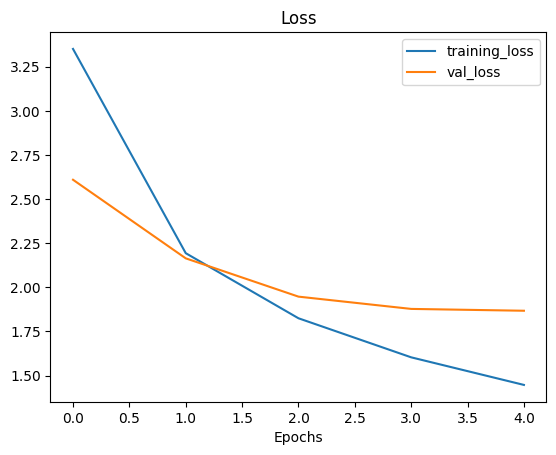

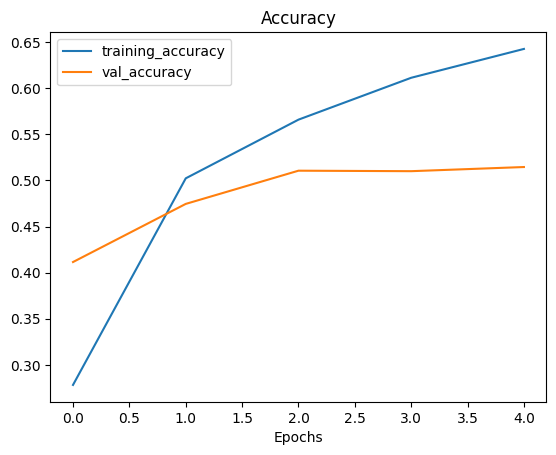

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-Tuning

Feature extraction transfer learning model is performing well. Let's try to fine-tune a few layers in the base model and see improvements.

Thanks to the **ModelCheckpoint** callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

We'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
base_model.trainable = True   # Unfreeze all of the layers

# Free layers again except the last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

### Compile the model again for Fine-tuning

We will use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large. (Learning_rate = 0.0001)

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

We'll start the training off where the feature extraction model left off using the **initial_epoch** parameter in the fit() function.

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 65s 226ms/step - loss: 1.2191 - accuracy: 0.6783 - val_loss: 1.7728 - val_accuracy: 0.5379
Epoch 6/10
237/237 [==============================] - 55s 231ms/step - loss: 1.0876 - accuracy: 0.7106 - val_loss: 1.7721 - val_accuracy: 0.5392
Epoch 7/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0018 - accuracy: 0.7325 - val_loss: 1.7764 - val_accuracy: 0.5395
Epoch 8/10
237/237 [==============================] - 55s 229ms/step - loss: 0.9526 - accuracy: 0.7468 - val_loss: 1.7994 - val_accuracy: 0.5328
Epoch 9/10
237/237 [==============================] - 47s 197ms/step - loss: 0.8879 - accuracy: 0.7596 - val_loss: 1.7632 - val_accuracy: 0.5413
Epoch 10/10
237/237 [==============================] - 51s 210ms/step - loss: 0.8326 - accuracy: 0.7770 - val_loss: 1.7603 - val_accuracy: 0.5437


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 64s 81ms/step - loss: 1.4856 - accuracy: 0.6071


[1.4855821132659912, 0.6071287393569946]

5
11
[0.27828383445739746, 0.5023102164268494, 0.5659406185150146, 0.6113531589508057, 0.6426402926445007, 0.6782838106155396, 0.7106270790100098, 0.7325412631034851, 0.7467986941337585, 0.7596039772033691, 0.7770296931266785]


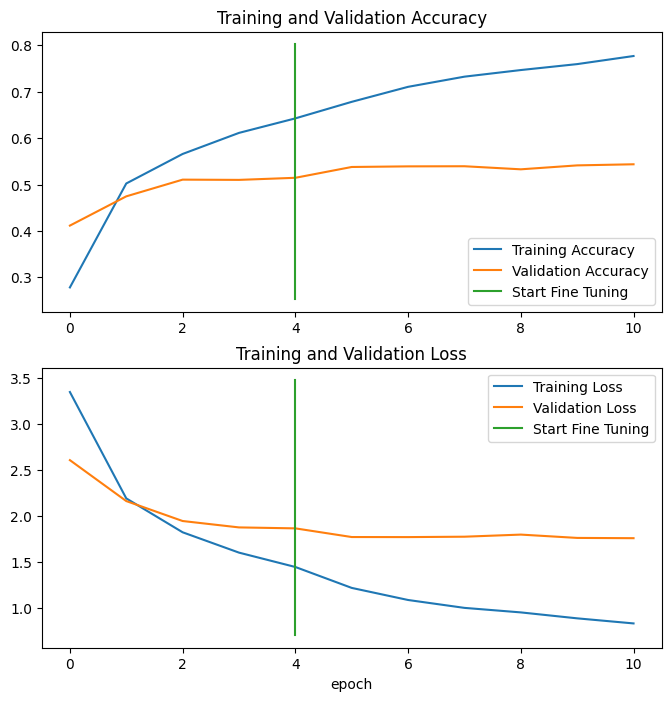

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Save the model

In [ ]:
# Mount your Google Drive to this workspace
# Save model to your drive

# model.save("drive/.../.../101_food_class_10_percent_saved_big_dog_model")

### Evaluating the Model

In [ ]:
# Download pre-trained model from Google Storage (this model was trained earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-05-18 14:02:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  11.5MB/s    in 3.9s    

2023-05-18 14:02:59 (11.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"

unzip_data(saved_model_path)

### Load Pre-trained model

In [ ]:
# model = tf.keras.models.load_model("drive/.../.../101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [ ]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 68s 75ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

In [47]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 68s 86ms/step


In [ ]:
# shape of predictions
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[10]  # prediction probability of sample 10

array([8.66758645e-01, 1.06682467e-08, 8.97231163e-04, 2.98574256e-11,
       1.19359580e-08, 2.52451636e-11, 1.78776531e-07, 1.49150314e-09,
       7.43701681e-02, 4.74565095e-05, 7.88795589e-08, 4.73205364e-10,
       9.88295884e-04, 4.71360728e-09, 9.51967086e-05, 3.80473146e-08,
       1.96486411e-07, 7.64913275e-04, 4.63440472e-07, 2.07787082e-07,
       3.97520722e-07, 6.02352031e-07, 2.73168621e-06, 7.80093444e-07,
       4.01718765e-08, 5.76192178e-08, 7.19973130e-08, 1.58951619e-11,
       2.75498496e-05, 6.87810189e-06, 1.76989190e-07, 2.09113641e-05,
       3.46416346e-05, 1.02143172e-11, 1.48571687e-07, 6.49165610e-10,
       1.37262277e-05, 3.96533096e-06, 2.23210191e-05, 2.05117967e-08,
       7.41940539e-06, 6.01402064e-07, 1.00604502e-05, 8.69767973e-08,
       1.21352750e-09, 4.20938818e-07, 1.28025931e-06, 3.94755872e-08,
       2.20744378e-11, 1.11111913e-04, 5.95505050e-08, 3.00479286e-09,
       2.45919097e-02, 1.49327952e-05, 4.66858739e-11, 2.53548904e-04,
      

In [ ]:
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

The class with the highest predicted probability by the model for sample 0: 52


**(layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax")**:  it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# Prediction of first 10 test samples
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the **unbatch()** method. Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the **argmax()** method to return the index of the label.

In [ ]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
y_labels[:5]  # Since test_data isn't shuffled, the y_labels array comes back in the same order as the pred_classes array.

[0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
np.isclose(loaded_accuracy, sklearn_accuracy)

True

In [ ]:
print(f"{loaded_accuracy - sklearn_accuracy}")

2.0097978059574473e-08


In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  '''
  >> A = np.array([2,0,1,8])
  >> A.shape
  Output: (4,)

  >> A[np.newaxis, :]
  Output: array([[2,0,1,8]])

  >> A[:, np.newaxis]
  Output: array([[2],
                 [0],
                 [1],
                 [8]]
  )
  '''
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    # Append Class F1 scores to a new dict
    class_f1_scores[class_names[int(k)]] = v['f1-score']

#class_f1_scores[:10]  # Show first 10 items of the Fruit Test data F1 score dict
for ix in range(10):
  print(f'{list(class_f1_scores.keys())[ix]} : {list(class_f1_scores.values())[ix]}')

apple_pie : 0.24056603773584903
baby_back_ribs : 0.5864406779661017
baklava : 0.6022304832713754
beef_carpaccio : 0.616822429906542
beef_tartare : 0.544080604534005
beet_salad : 0.41860465116279066
beignets : 0.7229357798165138
bibimbap : 0.7908902691511386
bread_pudding : 0.3866943866943867
breakfast_burrito : 0.5117370892018779


### Turn f1-scores into dataframe for visualization

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

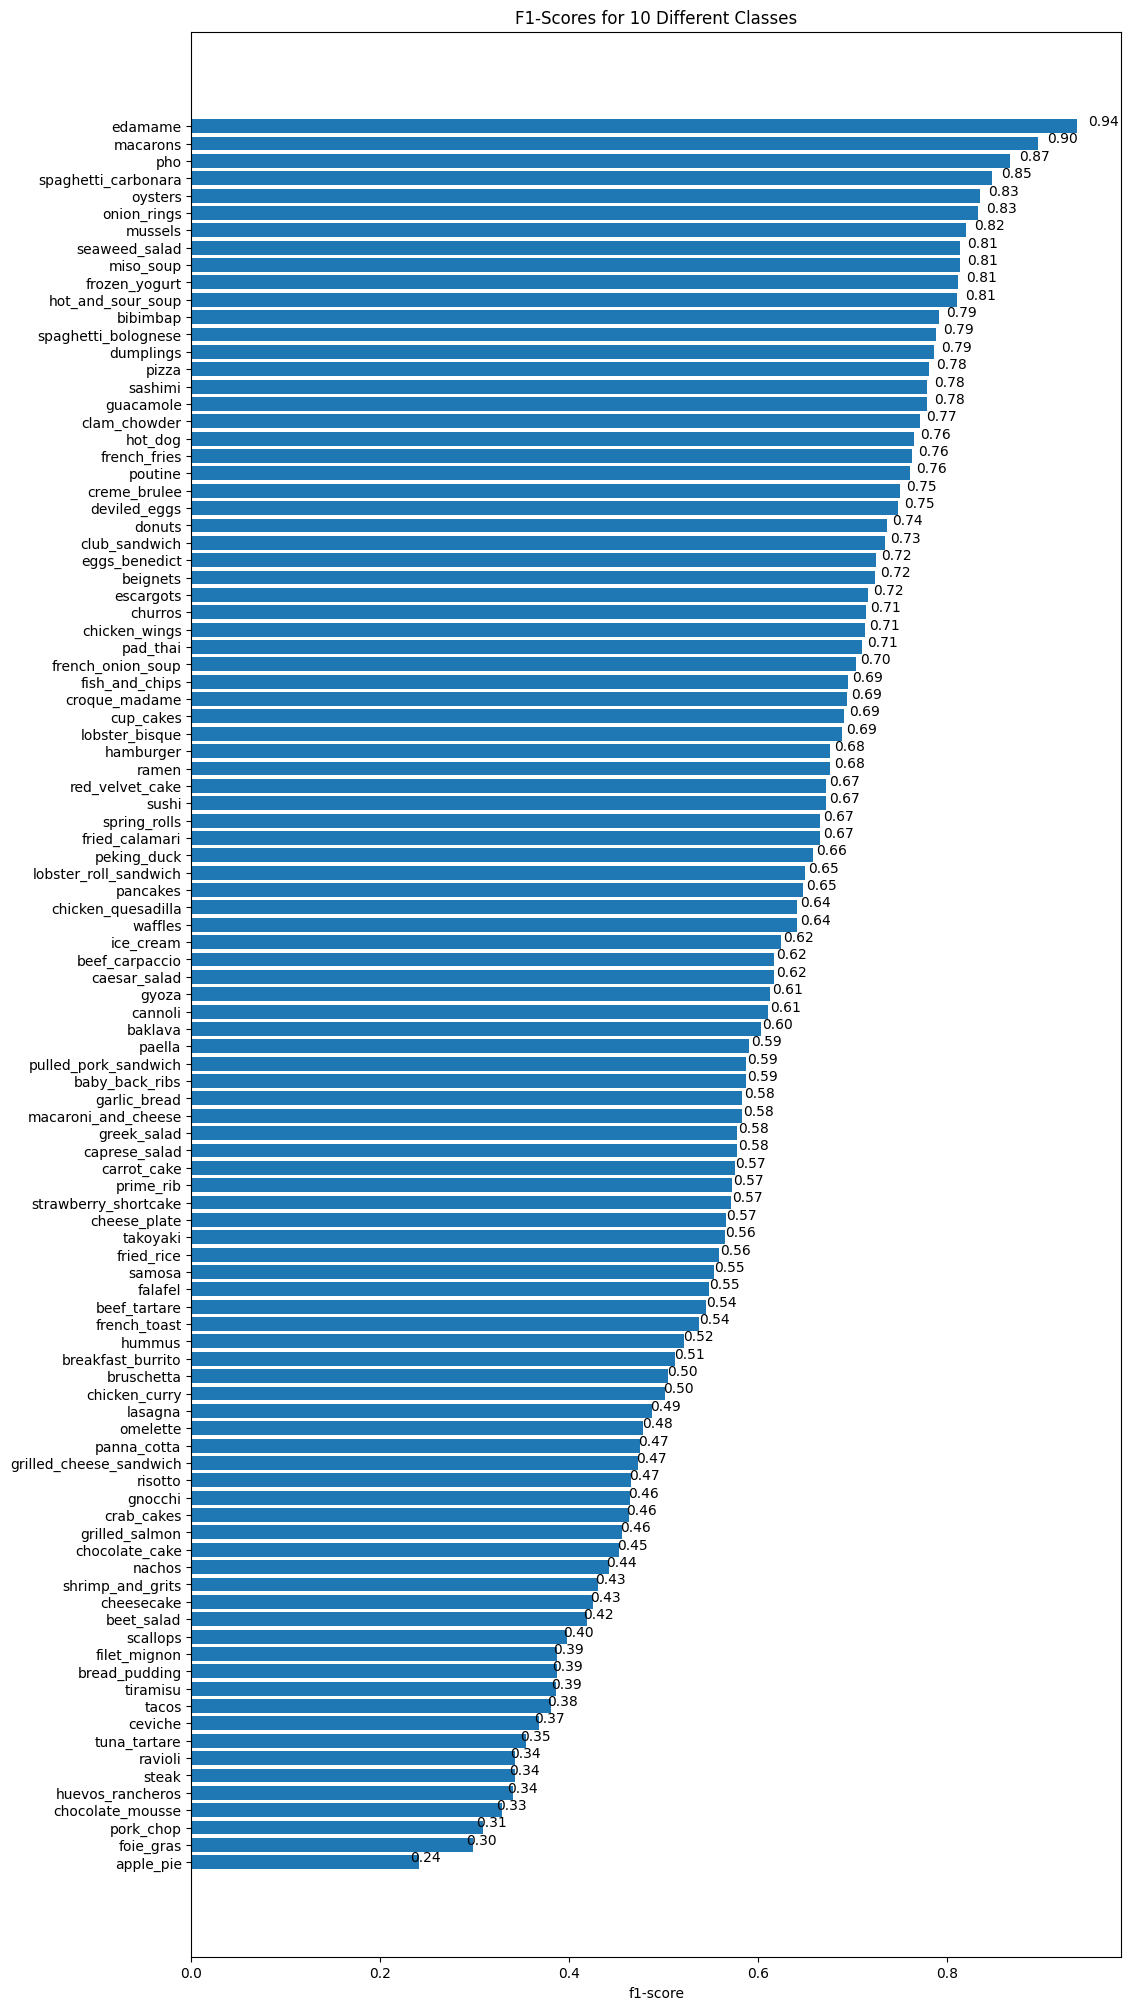

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Visualizing the Prediction Results

1/1 [==============================] - 0s 27ms/step


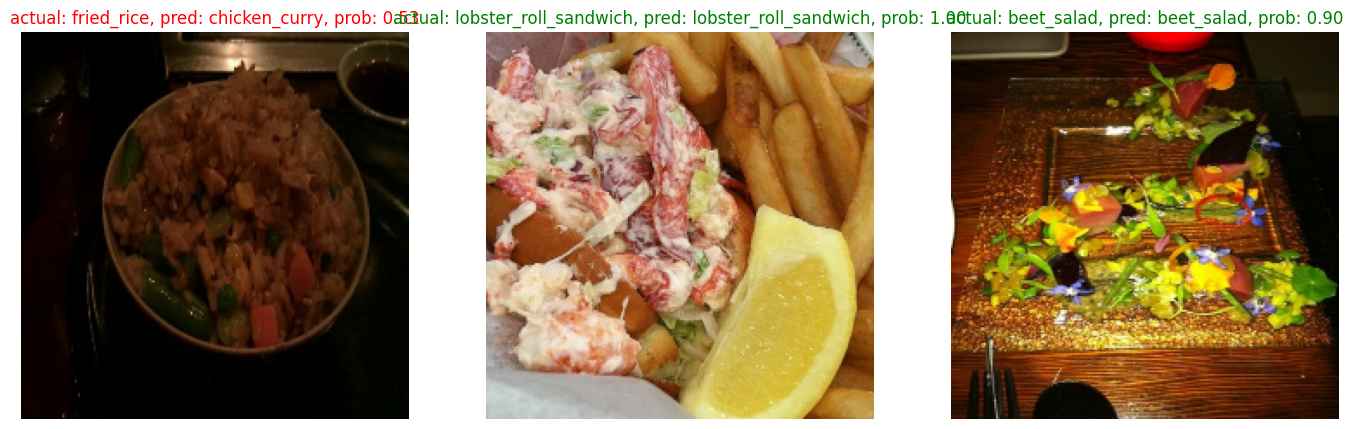

In [48]:
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(class_names)  # pick random class name
  filename = random.choice(os.listdir(os.path.join(test_dir, class_name)))
  # filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = os.path.join((test_dir + class_name), filename)
  # filepath = test_dir + class_name + "/" + filename

  # Load an image and make predictions
  img = load_and_prep_image(filepath, scale=False)  # Dont scale images for EfficientNet
  pred_prob = model.predict(tf.expand_dims(img, axis=0))  # [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Find the most wrong predictions

We try to find high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [49]:
# Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [55]:
len(pred_probs.max(axis=1))  # It will be the "pred_conf" key of the dataframe dict

25250

In [56]:
dataframe = {"img_path": filepaths,
             "y_true": y_labels,
             "y_pred": pred_classes,
             "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
             "y_true_classname": [class_names[i] for i in y_labels],
             "y_pred_classname": [class_names[i] for i in pred_classes]}

In [57]:
import pandas as pd

pred_df = pd.DataFrame(dataframe)
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847419        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658606        apple_pie  pulled_pork_sandwich  
4   0.367900        apple_pie             prime_rib

In [54]:
#! git clone https://github.com/mrdbourke/tensorflow-deep-learning.git

In [58]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367900        apple_pie             prime_rib         False

We know which predictions were **right** or **wrong** and along with their **prediction probabilities**, how about we get the 100 "**most wrong**" predictions by sorting for wrong predictions and descending prediction probabilties

In [63]:
wrong_preds = pred_df[pred_df['pred_correct'] == False]
wrong_preds

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
5      b'101_food_classes_10_percent/test/apple_pie/1...       0      61   
6      b'101_food_classes_10_percent/test/apple_pie/1...       0      29   
...                                                  ...     ...     ...   
25234  b'101_food_classes_10_percent/test/waffles/863...     100      83   
25236  b'101_food_classes_10_percent/test/waffles/896...     100      22   
25243  b'101_food_classes_10_percent/test/waffles/913...     100      16   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   

       pred_conf y_true_classname       y_pred_classname  pred_correct  
0       0.847419        apple_pie                  gyoza         False  
3       0.658606        apple_pie   pulled_pork_sandwich         False  
4       0.367900        apple_pie              prime_rib         False  
5       0.456755        apple_pie  lobster_roll_sandwich         False  
6       0.611244        apple_pie              cup_cakes         False  
...          ...              ...                    ...           ...  
25234   0.248723          waffles        red_velvet_cake         False  
25236   0.603934          waffles       chocolate_mousse         False  
25243   0.474086          waffles           cheese_plate         False  
25246   0.878028          waffles           cheese_plate         False  
25248   0.501949          waffles   strawberry_shortcake         False  

[9904 rows x 7 columns]

In [64]:
wrong_preds = wrong_preds.sort_values('pred_conf', ascending=False)[:100]  # Most wrong 100 predictions
wrong_preds

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996885            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

### Visualize some of the most wrong predictions

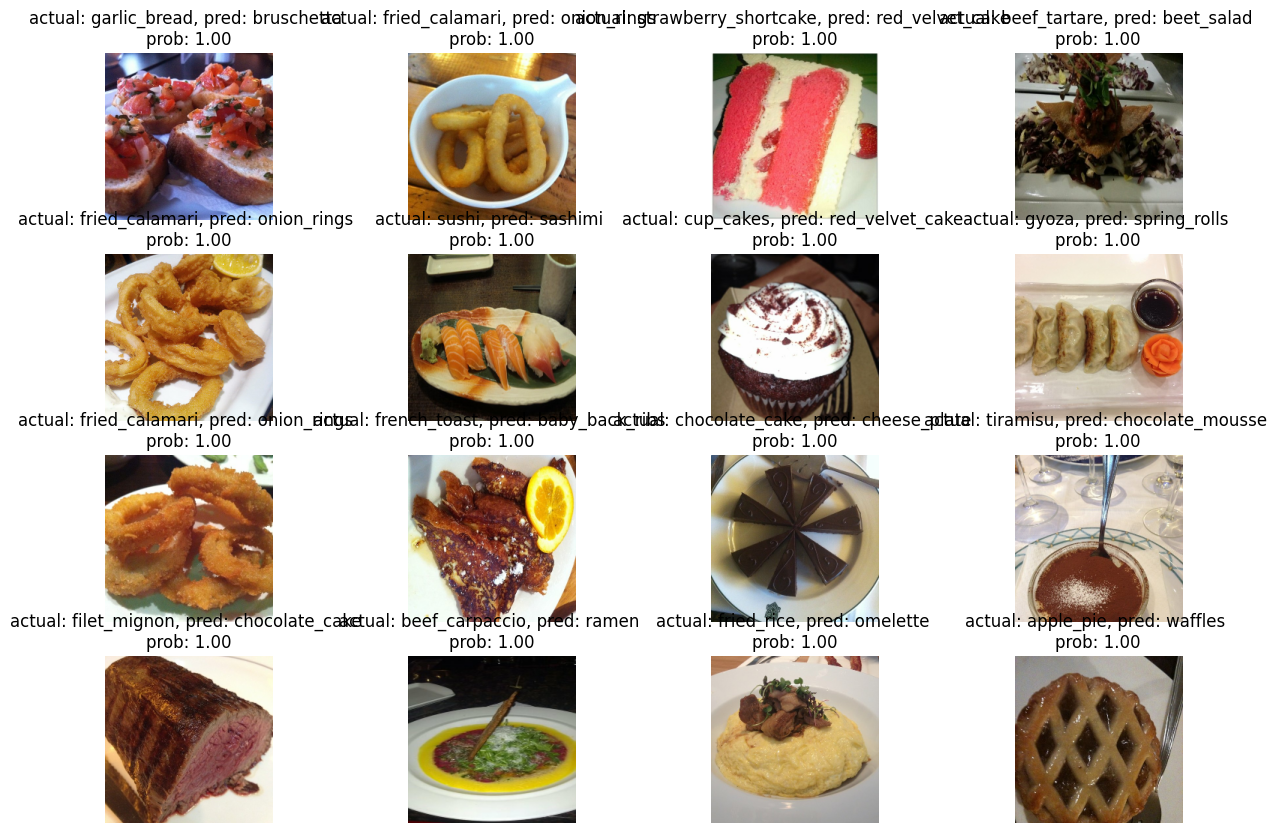

In [65]:
images_to_view = 16
start_ix = 11
plt.figure(figsize=(15,10))

for i, row in enumerate(wrong_preds[start_ix:start_ix+images_to_view].itertuples()):
  plt.subplot(4, 4, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).

### Testing the model with custom food images

In [66]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-05-18 14:57:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  5.82MB/s    in 2.2s    

2023-05-18 14:57:29 (5.82 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [67]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 43ms/step


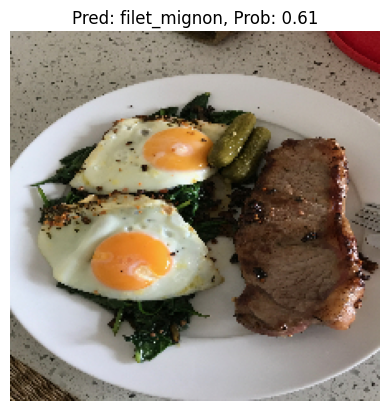

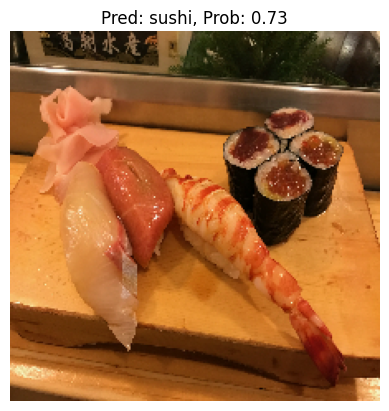

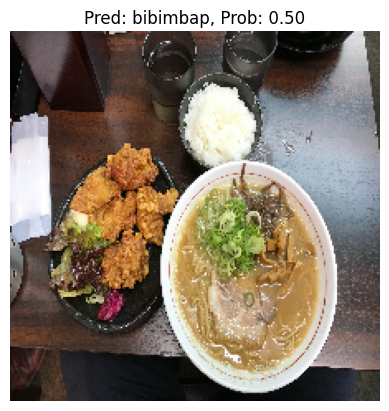

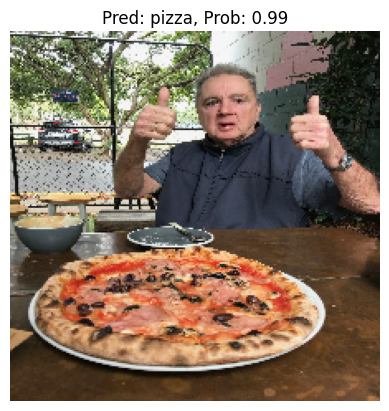

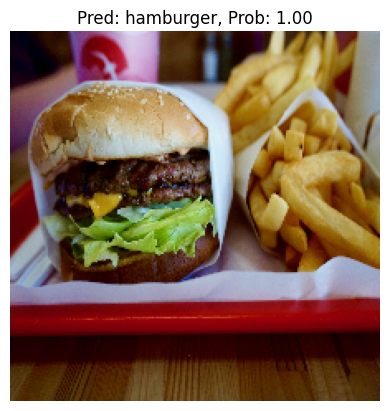

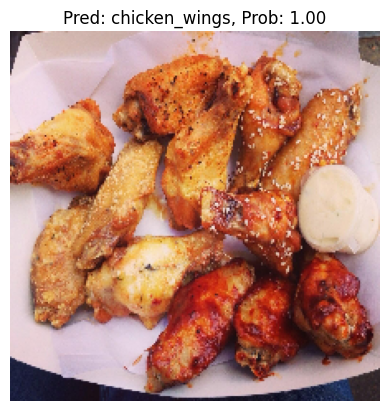

In [68]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))  # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.)    # imshow() requires float inputs to be normalized
  plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}")
  plt.axis(False)

### Reference

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb